In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
import kagglehub
from tensorflow.keras import layers

Load Data

In [2]:
import os
path = kagglehub.dataset_download('suchintikasarkar/sentiment-analysis-for-mental-health')

file_path = os.path.join(path, 'Combined Data.csv')
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


Data Cleansing

In [3]:
#dropping rows with null statements
df = df.dropna(subset=['statement'])

#converting statements and statuses to strings
df['statement'] = df['statement'].astype(str)
df['status'] = df['status'].astype(str)

<ipython-input-3-c53538df9f49>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['statement'] = df['statement'].astype(str)
<ipython-input-3-c53538df9f49>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status'] = df['status'].astype(str)


EDA

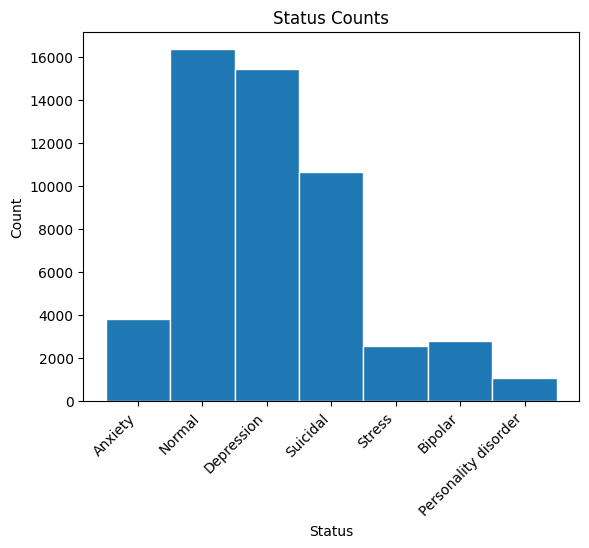

In [4]:
#histogram of status counts
plt.hist(df['status'], bins=range(8), align='left', edgecolor='white')
plt.xlabel('Status')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.title('Status Counts')
plt.show()

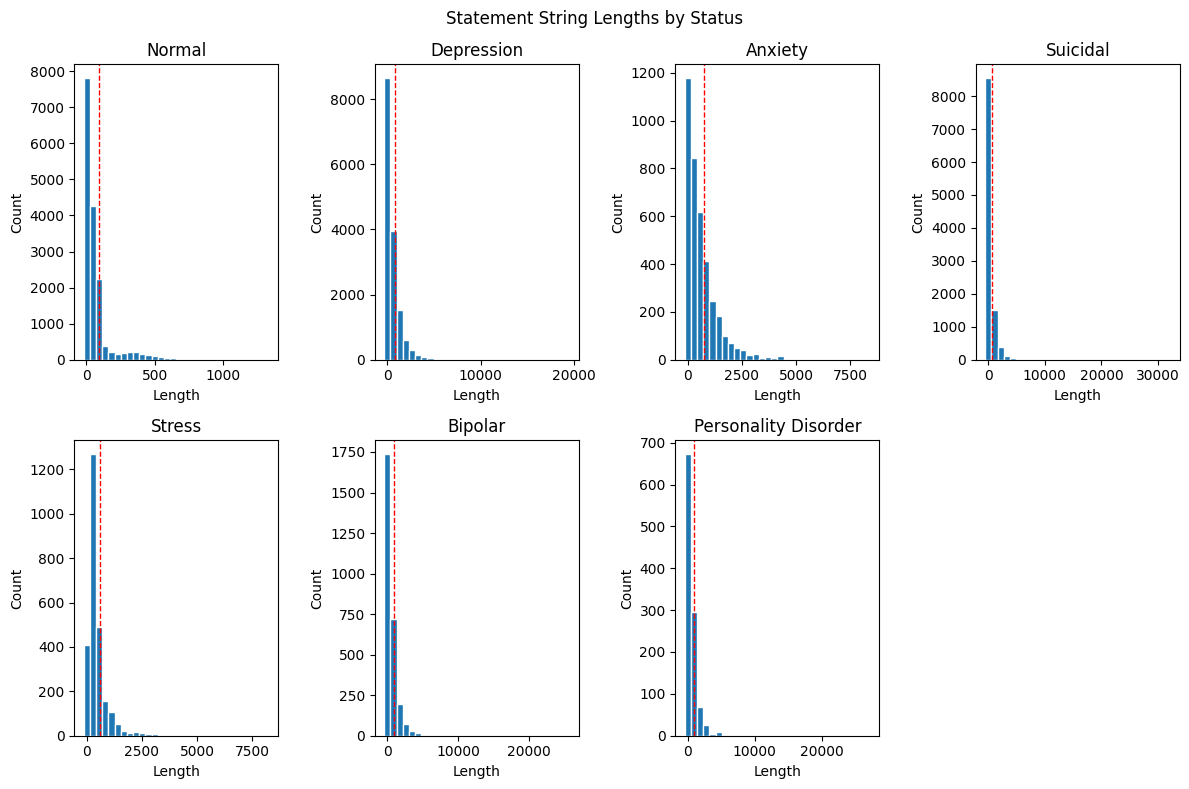

Mean Normal String Length: 90.2444471639234
Mean Depression String Length: 844.0311607374708
Mean Anxiety String Length: 764.6810726373341
Mean Suicidal String Length: 734.9673300788585
Mean Stress String Length: 613.5454194047159
Mean Bipolar String Length: 946.0749009722722


In [8]:
#histogram of statement string lengths by status
normal_lengths = [len(lst) for lst in df[df['status'] == 'Normal']['statement']]
depression_lengths = [len(lst) for lst in df[df['status'] == 'Depression']['statement']]
anxiety_lengths = [len(lst) for lst in df[df['status'] == 'Anxiety']['statement']]
suicidal_lengths = [len(lst) for lst in df[df['status'] == 'Suicidal']['statement']]
stress_lengths = [len(lst) for lst in df[df['status'] == 'Stress']['statement']]
bipolar_lengths = [len(lst) for lst in df[df['status'] == 'Bipolar']['statement']]
pd_lengths = [len(lst) for lst in df[df['status'] == 'Personality disorder']['statement']]

fig, axes = plt.subplots(2, 4, figsize=(12, 8))
fig.suptitle('Statement String Lengths by Status')
axes[0, 0].hist(normal_lengths, bins=30, align='left', edgecolor='white')
#plot mean
axes[0, 0].axvline(np.mean(normal_lengths), color='r', linestyle='dashed', linewidth=1)
axes[0, 0].set_xlabel('Length')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Normal')
axes[0, 1].hist(depression_lengths, bins=30, align='left', edgecolor='white')
axes[0, 1].axvline(np.mean(depression_lengths), color='r', linestyle='dashed', linewidth=1)
axes[0, 1].set_xlabel('Length')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Depression')
axes[0, 2].hist(anxiety_lengths, bins=30, align='left', edgecolor='white')
axes[0, 2].axvline(np.mean(anxiety_lengths), color='r', linestyle='dashed', linewidth=1)
axes[0, 2].set_xlabel('Length')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Anxiety')
axes[0, 3].hist(suicidal_lengths, bins=30, align='left', edgecolor='white')
axes[0, 3].axvline(np.mean(suicidal_lengths), color='r', linestyle='dashed', linewidth=1)
axes[0, 3].set_xlabel('Length')
axes[0, 3].set_ylabel('Count')
axes[0, 3].set_title('Suicidal')
axes[1, 0].hist(stress_lengths, bins=30, align='left', edgecolor='white')
axes[1, 0].axvline(np.mean(stress_lengths), color='r', linestyle='dashed', linewidth=1)
axes[1, 0].set_xlabel('Length')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Stress')
axes[1, 1].hist(bipolar_lengths, bins=30, align='left', edgecolor='white')
axes[1, 1].axvline(np.mean(bipolar_lengths), color='r', linestyle='dashed', linewidth=1)
axes[1, 1].set_xlabel('Length')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Bipolar')
axes[1, 2].hist(pd_lengths, bins=30, align='left', edgecolor='white')
axes[1, 2].axvline(np.mean(pd_lengths), color='r', linestyle='dashed', linewidth=1)
axes[1, 2].set_xlabel('Length')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Personality Disorder')
axes[1, 3].axis('off')
plt.tight_layout()
plt.show()

print("Mean Normal String Length:", np.mean(normal_lengths))
print("Mean Depression String Length:", np.mean(depression_lengths))
print("Mean Anxiety String Length:", np.mean(anxiety_lengths))
print("Mean Suicidal String Length:", np.mean(suicidal_lengths))
print("Mean Stress String Length:", np.mean(stress_lengths))
print("Mean Bipolar String Length:", np.mean(bipolar_lengths))


Data Preprocessing

In [9]:
#splitting data
from sklearn.model_selection import train_test_split
X = df['statement']
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [10]:
#tokenize and vectorize text
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

train_text = tf.convert_to_tensor(X_train)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

#applying text vectorization layer to train test and val
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_ds = train_ds.map(vectorize_text)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(vectorize_text)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(vectorize_text)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)